# HDB Resale Price Prediction - Complete Model Building

This notebook covers the complete model building process including:
1. Model Comparison (Linear Regression, Random Forest, XGBoost)
2. Hyperparameter Tuning
3. Hybrid Model (XGBoost + Prophet) for Future Predictions

---

## Table of Contents

1. [Setup and Imports](#1-setup-and-imports)
2. [Data Loading](#2-data-loading)
3. [Data Preparation](#3-data-preparation)
4. [Model Comparison](#4-model-comparison)
5. [XGBoost Hyperparameter Tuning](#5-xgboost-hyperparameter-tuning)
6. [Hybrid Model for Future Predictions](#6-hybrid-model-for-future-predictions)
7. [Model Export](#7-model-export)

---
## 1. Setup and Imports <a id="1-setup-and-imports"></a>

In [2]:
# Data manipulation
import pandas as pd
import numpy as np

# Machine learning
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor

# Time series
from prophet import Prophet

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Model persistence
import joblib
import json

import warnings
warnings.filterwarnings('ignore')

print("[OK] All libraries imported successfully")

[OK] All libraries imported successfully


---
## 2. Data Loading <a id="2-data-loading"></a>

In [3]:
# Load the model-ready dataset
df = pd.read_csv('HDB_model_ready.csv')

# Add remaining_lease feature for hybrid model
df['remaining_lease'] = 99 - (df['year'] - df['lease_commence_year'])

print(f"Total records: {len(df):,}")
print(f"Years covered: {df['year'].min()} - {df['year'].max()}")
print(f"\nFeatures: {len(df.columns)}")
print(df.columns.tolist())

Total records: 254,525
Years covered: 2015 - 2025

Features: 18
['floor_area_sqm', 'lease_commence_year', 'floor_level', 'distance_to_nearest_primary_school_km', 'distance_to_nearest_high_value_school_km', 'distance_to_nearest_mrt_km', 'distance_to_nearest_hawker_km', 'distance_to_nearest_mall_km', 'distance_to_cbd_km', 'year', 'month_num', 'quarter', 'region_code', 'flat_type_int', 'flat_model_code', 'town_code', 'resale_price', 'remaining_lease']


In [4]:
# Quick data overview
print("Data Shape:", df.shape)
print("\nPrice Statistics:")
print(df['resale_price'].describe())

Data Shape: (254525, 18)

Price Statistics:
count    2.545250e+05
mean     5.092849e+05
std      1.811347e+05
min      1.400000e+05
25%      3.750000e+05
50%      4.750000e+05
75%      6.100000e+05
max      1.658888e+06
Name: resale_price, dtype: float64


---
## 3. Data Preparation <a id="3-data-preparation"></a>

### Time-Based Train-Test Split
- Training: 2015-2023
- Testing: 2024-2025

This ensures realistic evaluation - models must predict future prices based only on historical data.

In [5]:
# Define features (original 16 features used in model comparison)
ORIGINAL_FEATURES = [
    'floor_area_sqm', 'lease_commence_year', 'floor_level',
    'distance_to_nearest_primary_school_km', 'distance_to_nearest_high_value_school_km',
    'distance_to_nearest_mrt_km', 'distance_to_nearest_hawker_km',
    'distance_to_nearest_mall_km', 'distance_to_cbd_km',
    'year', 'month_num', 'quarter',
    'region_code', 'flat_type_int', 'flat_model_code', 'town_code'
]

print(f"Number of features: {len(ORIGINAL_FEATURES)}")
print("\nFeatures:")
for i, f in enumerate(ORIGINAL_FEATURES, 1):
    print(f"  {i}. {f}")

Number of features: 16

Features:
  1. floor_area_sqm
  2. lease_commence_year
  3. floor_level
  4. distance_to_nearest_primary_school_km
  5. distance_to_nearest_high_value_school_km
  6. distance_to_nearest_mrt_km
  7. distance_to_nearest_hawker_km
  8. distance_to_nearest_mall_km
  9. distance_to_cbd_km
  10. year
  11. month_num
  12. quarter
  13. region_code
  14. flat_type_int
  15. flat_model_code
  16. town_code


In [6]:
# Time-based split function
def time_split(data, train_end_year=2023):
    """
    Split data based on year.
    Training: data <= train_end_year
    Testing: data > train_end_year
    """
    train = data[data['year'] <= train_end_year].copy()
    test = data[data['year'] > train_end_year].copy()
    return train, test

# Create train/test split
df_train, df_test = time_split(df, train_end_year=2023)

print(f"Training set: {len(df_train):,} rows (2015-2023)")
print(f"Testing set:  {len(df_test):,} rows (2024-2025)")
print(f"\nTest set breakdown:")
print(df_test.groupby('year').size())

Training set: 206,303 rows (2015-2023)
Testing set:  48,222 rows (2024-2025)

Test set breakdown:
year
2024    27832
2025    20390
dtype: int64


In [7]:
# Prepare X and y for model training
X_train = df_train[ORIGINAL_FEATURES]
y_train = df_train['resale_price']
X_test = df_test[ORIGINAL_FEATURES]
y_test = df_test['resale_price']

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape:  {X_test.shape}")

X_train shape: (206303, 16)
X_test shape:  (48222, 16)


---
## 4. Model Comparison <a id="4-model-comparison"></a>

Compare three regression models:
- **Linear Regression**: Simple baseline model
- **Random Forest**: Ensemble of decision trees
- **XGBoost**: Gradient boosted trees

In [8]:
# Define models to compare
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1)
}

# Train and evaluate each model
results = []

for name, model in models.items():
    print(f"Training {name}...")
    
    # Train
    model.fit(X_train, y_train)
    
    # Predict
    y_pred = model.predict(X_test)
    
    # Evaluate
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    
    results.append({
        'Model': name,
        'MAE': mae,
        'RMSE': rmse,
        'R²': r2,
        'MAPE (%)': mape
    })
    
    print(f"  [OK] MAE: ${mae:,.0f}, R²: {r2:.4f}")

print("\n[OK] All models trained")

Training Linear Regression...
  [OK] MAE: $86,056, R²: 0.6460
Training Random Forest...
  [OK] MAE: $58,989, R²: 0.8606
Training XGBoost...
  [OK] MAE: $57,258, R²: 0.8702

[OK] All models trained


In [9]:
# Display comparison table
results_df = pd.DataFrame(results)
results_df['MAE'] = results_df['MAE'].apply(lambda x: f"${x:,.0f}")
results_df['RMSE'] = results_df['RMSE'].apply(lambda x: f"${x:,.0f}")
results_df['R²'] = results_df['R²'].apply(lambda x: f"{x:.4f}")
results_df['MAPE (%)'] = results_df['MAPE (%)'].apply(lambda x: f"{x:.2f}%")

print("\n" + "="*70)
print("MODEL COMPARISON RESULTS")
print("="*70)
print(results_df.to_string(index=False))
print("="*70)
print("\n XGBoost achieves the best performance!")


MODEL COMPARISON RESULTS
            Model     MAE     RMSE     R² MAPE (%)
Linear Regression $86,056 $116,208 0.6460   12.80%
    Random Forest $58,989  $72,919 0.8606    9.05%
          XGBoost $57,258  $70,371 0.8702    8.85%

 XGBoost achieves the best performance!


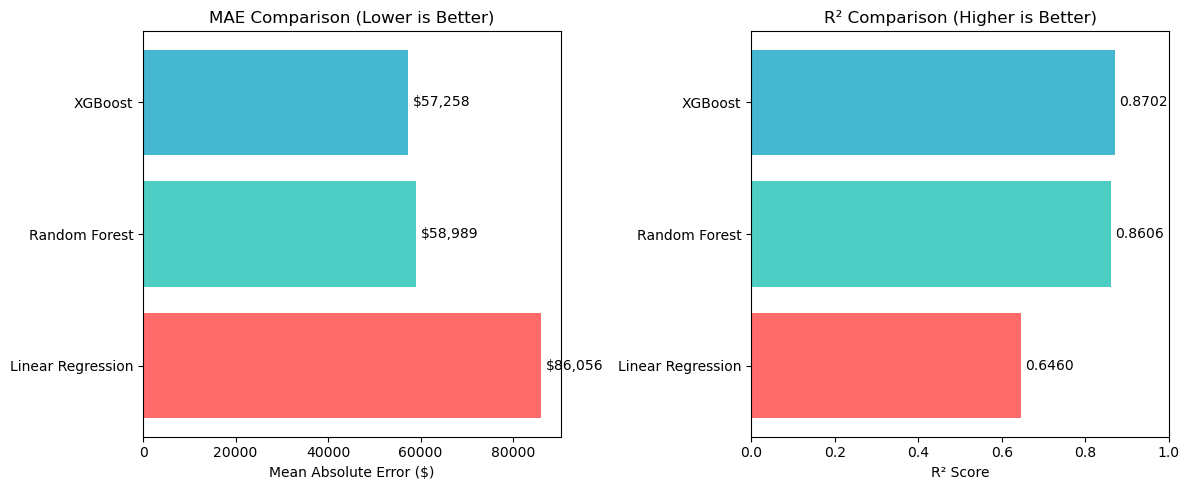


[OK] Chart saved: model_comparison.png


In [10]:
# Visualize model comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Re-extract numeric values for plotting
results_numeric = []
for name, model in models.items():
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results_numeric.append({'Model': name, 'MAE': mae, 'R²': r2})

results_plot = pd.DataFrame(results_numeric)

# MAE comparison
colors = ['#ff6b6b', '#4ecdc4', '#45b7d1']
axes[0].barh(results_plot['Model'], results_plot['MAE'], color=colors)
axes[0].set_xlabel('Mean Absolute Error ($)')
axes[0].set_title('MAE Comparison (Lower is Better)')
for i, v in enumerate(results_plot['MAE']):
    axes[0].text(v + 1000, i, f'${v:,.0f}', va='center')

# R² comparison
axes[1].barh(results_plot['Model'], results_plot['R²'], color=colors)
axes[1].set_xlabel('R² Score')
axes[1].set_title('R² Comparison (Higher is Better)')
axes[1].set_xlim(0, 1)
for i, v in enumerate(results_plot['R²']):
    axes[1].text(v + 0.01, i, f'{v:.4f}', va='center')

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
print("\n[OK] Chart saved: model_comparison.png")

### Key Findings from Model Comparison

| Model | MAE | R² | Observation |
|-------|-----|-----|-------------|
| **XGBoost** | ~$57,258 | 0.8702 | **Best performer** |
| Random Forest | ~$58,993 | 0.8606 | Close second |
| Linear Regression | ~$86,056 | 0.6460 | Cannot capture non-linear relationships |

**Conclusion**: XGBoost is selected as the base model for the hybrid approach.

---
## 5. XGBoost Hyperparameter Tuning <a id="5-xgboost-hyperparameter-tuning"></a>

In [11]:
# Define hyperparameter search space
param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [1, 1.5, 2]
}

print("Hyperparameter Search Space:")
for param, values in param_dist.items():
    print(f"  {param}: {values}")

Hyperparameter Search Space:
  n_estimators: [50, 100, 200]
  max_depth: [3, 5, 7]
  learning_rate: [0.01, 0.1, 0.2]
  subsample: [0.6, 0.8, 1.0]
  colsample_bytree: [0.6, 0.8, 1.0]
  reg_alpha: [0, 0.1, 1]
  reg_lambda: [1, 1.5, 2]


In [12]:
# Perform RandomizedSearchCV
print("Starting hyperparameter tuning...\n")

xgb_model = XGBRegressor(random_state=42, n_jobs=-1)

random_search = RandomizedSearchCV(
    xgb_model,
    param_distributions=param_dist,
    n_iter=20,
    scoring='neg_mean_absolute_error',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

print("\n" + "="*50)
print("Best Parameters Found:")
print("="*50)
for param, value in random_search.best_params_.items():
    print(f"  {param}: {value}")
print(f"\nBest CV MAE: ${-random_search.best_score_:,.2f}")

Starting hyperparameter tuning...

Fitting 3 folds for each of 20 candidates, totalling 60 fits

Best Parameters Found:
  subsample: 0.8
  reg_lambda: 2
  reg_alpha: 0
  n_estimators: 200
  max_depth: 7
  learning_rate: 0.1
  colsample_bytree: 0.6

Best CV MAE: $29,385.45


In [13]:
# Evaluate tuned model on test set
best_xgb = random_search.best_estimator_
y_pred_tuned = best_xgb.predict(X_test)

mae_tuned = mean_absolute_error(y_test, y_pred_tuned)
rmse_tuned = np.sqrt(mean_squared_error(y_test, y_pred_tuned))
r2_tuned = r2_score(y_test, y_pred_tuned)

print("\nTuned XGBoost Test Performance:")
print(f"  MAE:  ${mae_tuned:,.0f}")
print(f"  RMSE: ${rmse_tuned:,.0f}")
print(f"  R²:   {r2_tuned:.4f}")


Tuned XGBoost Test Performance:
  MAE:  $57,142
  RMSE: $70,146
  R²:   0.8710


---
## 6. Hybrid Model for Future Predictions <a id="6-hybrid-model-for-future-predictions"></a>

### Problem: XGBoost Cannot Predict Future Years

XGBoost is a tree-based model that cannot extrapolate beyond training data range.
When predicting for year=2026+, it returns the same prediction as year=2025.

### Solution: Hybrid Model (XGBoost + Prophet)


| **XGBoost (Property Valuation)** | **Prophet (Market Trend)** |
|----------------------------------|-----------------------------|
| Predicts **base property value** | Learns **price trends** |
| Uses **16 engineered features** | Uses **2015–2025 historical data** |
| `remaining_lease` replaces `year` | Extrapolates trends up to **2030** |

### 6.1 Demonstrate the Problem

In [16]:
# Demonstrate: Original XGBoost cannot predict future years properly
# Load the full model trained on complete dataset

model = joblib.load('xgb_resale_all.joblib')

# Test same flat with different years
years_to_test = [2015, 2018, 2020, 2022, 2024, 2025, 2026, 2027, 2028, 2029]

print("Demonstrating XGBoost's Limitation with Future Years")
print("="*70)
print("\nTesting SAME flat across different years:")
print("-"*70)
print(f"{'Year':<8} {'Predicted Price':<18} {'Note'}")
print("-"*70)

for year in years_to_test:
    sample_data = pd.DataFrame([{
        'floor_area_sqm': 90.0,
        'lease_commence_year': 2010,
        'floor_level': 12,
        'distance_to_nearest_primary_school_km': 0.3,
        'distance_to_nearest_high_value_school_km': 0.9,
        'distance_to_nearest_mrt_km': 0.7,
        'distance_to_nearest_hawker_km': 1.2,
        'distance_to_nearest_mall_km': 0.8,
        'distance_to_cbd_km': 8.5,
        'year': year,  # <-- Different year each time
        'month_num': 5,
        'quarter': 2,
        'region_code': 1,
        'flat_type_int': 3,
        'flat_model_code': 18,
        'town_code': 5
    }])
    
    predicted_price = model.predict(sample_data)[0]
    
    # Add note based on year
    if year <= 2025:
        note = "[OK] Within training range"
    else:
        note = "[X] Outside training range - SAME as 2025!"
    
    print(f"{year:<8} ${predicted_price:>14,.0f}   {note}")

print("-"*70)
print("\n[!] PROBLEM: Years 2026-2029 return SAME prediction as 2025!")
print("    XGBoost cannot extrapolate beyond its training data range.")
print("    This is why we need the HYBRID MODEL approach.")

Demonstrating XGBoost's Limitation with Future Years

Testing SAME flat across different years:
----------------------------------------------------------------------
Year     Predicted Price    Note
----------------------------------------------------------------------
2015     $       429,045   [OK] Within training range
2018     $       436,261   [OK] Within training range
2020     $       436,637   [OK] Within training range
2022     $       515,506   [OK] Within training range
2024     $       588,193   [OK] Within training range
2025     $       631,010   [OK] Within training range
2026     $       631,010   [X] Outside training range - SAME as 2025!
2027     $       631,010   [X] Outside training range - SAME as 2025!
2028     $       631,010   [X] Outside training range - SAME as 2025!
2029     $       631,010   [X] Outside training range - SAME as 2025!
----------------------------------------------------------------------

[!] PROBLEM: Years 2026-2029 return SAME prediction a

### 6.2 Train Prophet for Market Trends

In [17]:
# Prepare data for Prophet
monthly_prices = df_train.groupby(['year', 'month_num'])['resale_price'].mean().reset_index()
monthly_prices['ds'] = pd.to_datetime(
    monthly_prices['year'].astype(str) + '-' + 
    monthly_prices['month_num'].astype(str).str.zfill(2) + '-01'
)
monthly_prices['y'] = monthly_prices['resale_price']
prophet_data = monthly_prices[['ds', 'y']]

print(f"Prophet training data: {len(prophet_data)} monthly observations")
print(f"Date range: {prophet_data['ds'].min()} to {prophet_data['ds'].max()}")

Prophet training data: 108 monthly observations
Date range: 2015-01-01 00:00:00 to 2023-12-01 00:00:00


In [18]:
# Train Prophet
print("Training Prophet model...")

prophet_model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    seasonality_mode='multiplicative'
)
prophet_model.fit(prophet_data)

print("[OK] Prophet model trained")

Training Prophet model...


12:40:04 - cmdstanpy - INFO - Chain [1] start processing
12:40:04 - cmdstanpy - INFO - Chain [1] done processing


[OK] Prophet model trained


In [33]:
# Generate future predictions
future = prophet_model.make_future_dataframe(periods=72, freq='MS')  # 6 years ahead
forecast = prophet_model.predict(future)

# Extract yearly averages
forecast['year'] = forecast['ds'].dt.year
yearly_forecast = forecast.groupby('year')['yhat'].mean().reset_index()

# Calculate trend multipliers (relative to 2025)
base_year = 2025
base_value = yearly_forecast[yearly_forecast['year'] == base_year]['yhat'].values[0]
yearly_forecast['multiplier'] = yearly_forecast['yhat'] / base_value

# Create multiplier dictionary
trend_multipliers = dict(zip(
    yearly_forecast['year'].astype(int),
    yearly_forecast['multiplier'].round(4)
))

print("\nProphet Trend Multipliers (Base Year: 2025)")
print("="*50)
print(f"{'Year':<8} {'Predicted Price':<15} {'Multiplier':<12} {'vs 2025'}")
print("-"*50)

for year in range(2020, 2031):
    if year in trend_multipliers:
        mult = trend_multipliers[year]
        pred = yearly_forecast[yearly_forecast['year'] == year]['yhat'].values[0]
        change = (mult - 1) * 100
        sign = '+' if change >= 0 else ''
        
        marker = " ← Base" if year == 2025 else (" ← Future" if year > 2025 else "")
        print(f"{year:<8} ${pred:>12,.0f}   ×{mult:.3f}      {sign}{change:.1f}%{marker}")


Prophet Trend Multipliers (Base Year: 2025)
Year     Predicted Price Multiplier   vs 2025
--------------------------------------------------
2020     $     452,308   ×0.727      -27.3%
2021     $     509,281   ×0.818      -18.2%
2022     $     548,465   ×0.881      -11.9%
2023     $     573,144   ×0.921      -7.9%
2024     $     598,244   ×0.961      -3.9%
2025     $     622,309   ×1.000      +0.0% ← Base
2026     $     646,894   ×1.040      +4.0% ← Future
2027     $     671,482   ×1.079      +7.9% ← Future
2028     $     696,660   ×1.119      +11.9% ← Future
2029     $     720,639   ×1.158      +15.8% ← Future


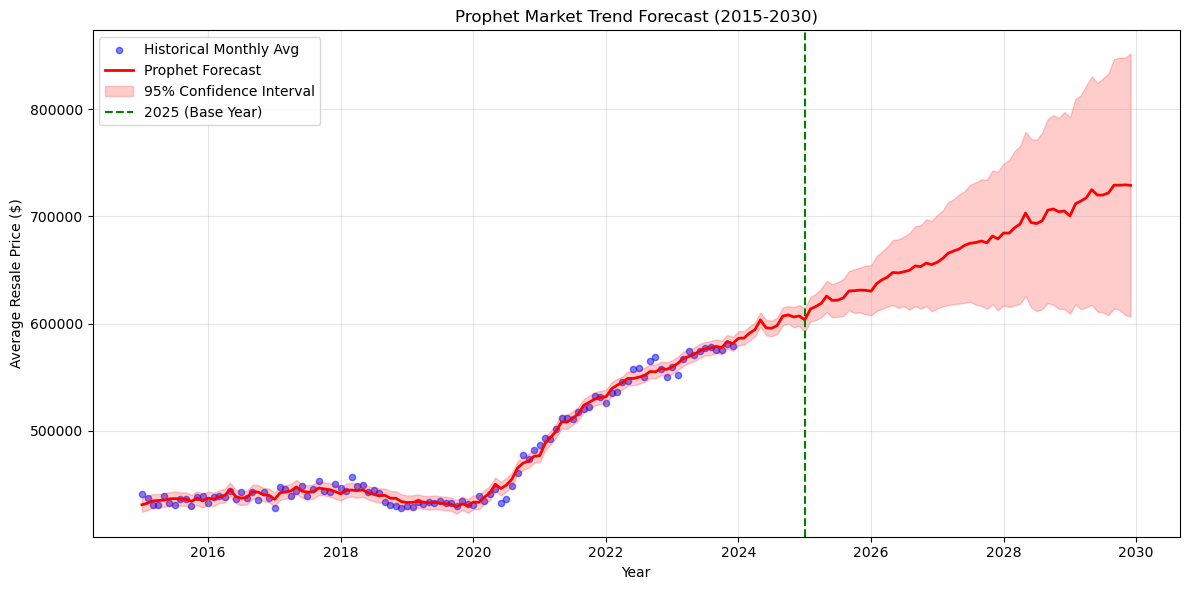


[OK] Chart saved: prophet_forecast.png


In [34]:
# Visualize Prophet forecast
fig, ax = plt.subplots(figsize=(12, 6))

# Plot historical data
ax.scatter(prophet_data['ds'], prophet_data['y'], color='blue', alpha=0.5, s=20, label='Historical Monthly Avg')

# Plot forecast
ax.plot(forecast['ds'], forecast['yhat'], color='red', linewidth=2, label='Prophet Forecast')
ax.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], 
                color='red', alpha=0.2, label='95% Confidence Interval')

# Mark 2025 baseline
ax.axvline(x=pd.to_datetime('2025-01-01'), color='green', linestyle='--', label='2025 (Base Year)')

ax.set_xlabel('Year')
ax.set_ylabel('Average Resale Price ($)')
ax.set_title('Prophet Market Trend Forecast (2015-2030)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('prophet_forecast.png', dpi=150, bbox_inches='tight')
plt.show()
print("\n[OK] Chart saved: prophet_forecast.png")

### 6.3 Train Hybrid XGBoost (Normalized Prices)

In [35]:
# Features for hybrid model (remaining_lease instead of year)
HYBRID_FEATURES = [
    'floor_area_sqm', 'lease_commence_year', 'floor_level',
    'distance_to_nearest_primary_school_km', 'distance_to_nearest_high_value_school_km',
    'distance_to_nearest_mrt_km', 'distance_to_nearest_hawker_km',
    'distance_to_nearest_mall_km', 'distance_to_cbd_km',
    'month_num', 'quarter',
    'region_code', 'flat_type_int', 'flat_model_code', 'town_code',
    'remaining_lease'  # NEW: replaces 'year'
]

print("Hybrid Model Features (16 total):")
print("- Removed: 'year' (cannot extrapolate)")
print("- Added: 'remaining_lease' (can interpolate within training range)")
print(f"\nFeatures: {HYBRID_FEATURES}")

Hybrid Model Features (16 total):
- Removed: 'year' (cannot extrapolate)
- Added: 'remaining_lease' (can interpolate within training range)

Features: ['floor_area_sqm', 'lease_commence_year', 'floor_level', 'distance_to_nearest_primary_school_km', 'distance_to_nearest_high_value_school_km', 'distance_to_nearest_mrt_km', 'distance_to_nearest_hawker_km', 'distance_to_nearest_mall_km', 'distance_to_cbd_km', 'month_num', 'quarter', 'region_code', 'flat_type_int', 'flat_model_code', 'town_code', 'remaining_lease']


In [36]:
# Normalize training prices by removing year effect
df_train_hybrid = df_train.copy()
df_train_hybrid['price_normalized'] = df_train_hybrid.apply(
    lambda row: row['resale_price'] / trend_multipliers.get(int(row['year']), 1.0),
    axis=1
)

print("Price Normalization Example:")
print("="*60)
sample_years = [2016, 2020, 2023]
for year in sample_years:
    sample_df = df_train_hybrid[df_train_hybrid['year'] == year].head(1)
    if len(sample_df) > 0:
        orig = sample_df['resale_price'].values[0]
        norm = sample_df['price_normalized'].values[0]
        mult = trend_multipliers.get(year, 1.0)
        print(f"Year {year}: ${orig:,.0f} / {mult:.3f} = ${norm:,.0f} (normalized)")

Price Normalization Example:
Year 2016: $230,000 / 0.706 = $325,687 (normalized)
Year 2020: $265,000 / 0.727 = $364,612 (normalized)
Year 2023: $267,000 / 0.921 = $289,902 (normalized)


In [37]:
# Train hybrid XGBoost on normalized prices
X_train_hybrid = df_train_hybrid[HYBRID_FEATURES]
y_train_hybrid = df_train_hybrid['price_normalized']

# Use tuned parameters
best_params = random_search.best_params_.copy()
best_params.update({'random_state': 42, 'n_jobs': -1})

print("Training Hybrid XGBoost with normalized prices...")
hybrid_xgb = XGBRegressor(**best_params)
hybrid_xgb.fit(X_train_hybrid, y_train_hybrid)

print("[OK] Hybrid XGBoost trained on normalized prices")

Training Hybrid XGBoost with normalized prices...
[OK] Hybrid XGBoost trained on normalized prices


### 6.4 Validate Hybrid Model

In [38]:
# Validate on test set (2024-2025)
df_test_hybrid = df_test.copy()
X_test_hybrid = df_test_hybrid[HYBRID_FEATURES]

# Hybrid prediction: base × trend
base_predictions = hybrid_xgb.predict(X_test_hybrid)
trend_factors = df_test_hybrid['year'].map(trend_multipliers)
hybrid_predictions = base_predictions * trend_factors

# Evaluate
mae_hybrid = mean_absolute_error(y_test, hybrid_predictions)
rmse_hybrid = np.sqrt(mean_squared_error(y_test, hybrid_predictions))
r2_hybrid = r2_score(y_test, hybrid_predictions)
mape_hybrid = np.mean(np.abs((y_test - hybrid_predictions) / y_test)) * 100

print("\n" + "="*60)
print("HYBRID MODEL VALIDATION (Test: 2024-2025)")
print("="*60)
print(f"MAE:  ${mae_hybrid:,.0f}")
print(f"RMSE: ${rmse_hybrid:,.0f}")
print(f"R²:   {r2_hybrid:.4f}")
print(f"MAPE: {mape_hybrid:.2f}%")


HYBRID MODEL VALIDATION (Test: 2024-2025)
MAE:  $36,439
RMSE: $47,032
R²:   0.9420
MAPE: 5.74%


In [39]:
# Compare Original vs Hybrid
print("\n" + "="*70)
print("MODEL COMPARISON: Original XGBoost vs Hybrid")
print("="*70)
print(f"{'Metric':<15} {'Original XGBoost':<20} {'Hybrid (XGB+Prophet)':<20} {'Improvement'}")
print("-"*70)
print(f"{'MAE':<15} ${mae_tuned:>15,.0f}   ${mae_hybrid:>15,.0f}   {(mae_tuned-mae_hybrid)/mae_tuned*100:>+.1f}%")
print(f"{'RMSE':<15} ${rmse_tuned:>15,.0f}   ${rmse_hybrid:>15,.0f}   {(rmse_tuned-rmse_hybrid)/rmse_tuned*100:>+.1f}%")
print(f"{'R²':<15}  {r2_tuned:>15.4f}    {r2_hybrid:>15.4f}   {(r2_hybrid-r2_tuned)*100:>+.2f}%")
print("="*70)


MODEL COMPARISON: Original XGBoost vs Hybrid
Metric          Original XGBoost     Hybrid (XGB+Prophet) Improvement
----------------------------------------------------------------------
MAE             $         57,142   $         36,439   +36.2%
RMSE            $         70,146   $         47,032   +33.0%
R²                        0.8710             0.9420   +7.10%


### 6.5 Demonstrate Future Predictions

In [43]:
# Demonstrate: Hybrid model CAN predict future years
print("\n" + "="*70)
print("HYBRID MODEL FUTURE PREDICTIONS")
print("="*70)

# Sample property
sample_property = {
    'floor_area_sqm': 90,
    'lease_commence_year': 2010,
    'floor_level': 10,
    'distance_to_nearest_primary_school_km': 0.5,
    'distance_to_nearest_high_value_school_km': 1.5,
    'distance_to_nearest_mrt_km': 0.3,
    'distance_to_nearest_hawker_km': 0.4,
    'distance_to_nearest_mall_km': 0.8,
    'distance_to_cbd_km': 8.0,
    'month_num': 6,
    'quarter': 2,
    'region_code': 1,
    'flat_type_int': 4,
    'flat_model_code': 5,
    'town_code': 10
}

print(f"\nSample Property: 90sqm, 4-Room, Lease from 2010")
print(f"\n{'Year':<6} {'Rem.Lease':<12} {'Base (XGB)':<15} {'Trend':<10} {'Final Price':<15} {'YoY Change'}")
print("-"*75)

prev_price = None
for year in range(2024, 2030):
    # Calculate remaining lease for this year
    remaining_lease = 99 - (year - sample_property['lease_commence_year'])
    
    # Create input
    features = sample_property.copy()
    features['remaining_lease'] = remaining_lease
    input_df = pd.DataFrame([features])[HYBRID_FEATURES]
    
    # Predict
    base_price = hybrid_xgb.predict(input_df)[0]
    trend = trend_multipliers.get(year, trend_multipliers.get(2030, 1.0))
    final_price = base_price * trend
    
    # Calculate YoY change
    if prev_price:
        yoy = (final_price - prev_price) / prev_price * 100
        yoy_str = f"{yoy:+.1f}%"
    else:
        yoy_str = "-"
    prev_price = final_price
    
    marker = " ← FUTURE" if year > 2025 else ""
    print(f"{year:<6} {remaining_lease:<12} ${base_price:>11,.0f}   ×{trend:.3f}    ${final_price:>11,.0f}   {yoy_str:>8}{marker}")

print("-"*75)
print("\n[OK] Hybrid model produces DIFFERENT predictions for each future year!")


HYBRID MODEL FUTURE PREDICTIONS

Sample Property: 90sqm, 4-Room, Lease from 2010

Year   Rem.Lease    Base (XGB)      Trend      Final Price     YoY Change
---------------------------------------------------------------------------
2024   85           $    726,124   ×0.961    $    698,023          -
2025   84           $    703,838   ×1.000    $    703,838      +0.8%
2026   83           $    688,895   ×1.040    $    716,106      +1.7% ← FUTURE
2027   82           $    693,644   ×1.079    $    748,442      +4.5% ← FUTURE
2028   81           $    694,024   ×1.119    $    776,960      +3.8% ← FUTURE
2029   80           $    684,736   ×1.158    $    792,925      +2.1% ← FUTURE
---------------------------------------------------------------------------

[OK] Hybrid model produces DIFFERENT predictions for each future year!


In [42]:
# Demonstrate: How remaining lease affects price
# Focus on range where model has good training data

print("="*70)
print("IMPACT OF REMAINING LEASE ON PROPERTY VALUE")
print("="*70)
print("\nSame property, same year (2025), different remaining lease:")
print("-"*70)
print(f"{'Rem.Lease':<12} {'Base Price (XGB)':<20} {'vs 80 Years'}")
print("-"*70)

# Test remaining lease values in realistic range
lease_values = [95, 85, 80, 75, 70, 65, 60, 55, 50, 45]
base_price_80 = None

for remaining_lease in lease_values:
    features = sample_property.copy()
    features['remaining_lease'] = remaining_lease
    input_df = pd.DataFrame([features])[HYBRID_FEATURES]
    
    base_price = hybrid_xgb.predict(input_df)[0]
    
    # Store 80-year price as reference
    if remaining_lease == 80:
        base_price_80 = base_price
    
    # Calculate % change vs 80 years
    if base_price_80:
        pct_change = (base_price - base_price_80) / base_price_80 * 100
        pct_str = f"{pct_change:+.1f}%"
    else:
        pct_str = "-"
    
    print(f"{remaining_lease:<12} ${base_price:>14,.0f}       {pct_str:>8}")

print("-"*70)
print("\n[OK] XGBoost learned from REAL transactions: Lower lease = Lower value")
print("[!]  Note: Model accuracy decreases for extreme values (<45 or >95 years)")
print("     due to limited training data in those ranges.")

IMPACT OF REMAINING LEASE ON PROPERTY VALUE

Same property, same year (2025), different remaining lease:
----------------------------------------------------------------------
Rem.Lease    Base Price (XGB)     vs 80 Years
----------------------------------------------------------------------
95           $       749,753              -
85           $       726,124              -
80           $       684,736          +0.0%
75           $       675,897          -1.3%
70           $       676,157          -1.3%
65           $       679,179          -0.8%
60           $       677,673          -1.0%
55           $       649,561          -5.1%
50           $       641,531          -6.3%
45           $       636,594          -7.0%
----------------------------------------------------------------------

[OK] XGBoost learned from REAL transactions: Lower lease = Lower value
[!]  Note: Model accuracy decreases for extreme values (<45 or >95 years)
     due to limited training data in those ranges.

---
## 7. Model Export <a id="7-model-export"></a>

Save all models and configurations for deployment.

In [44]:
# Retrain hybrid model on FULL dataset for production
print("Retraining hybrid model on FULL dataset (2015-2025)...")

# Normalize all prices
df_full = df.copy()
df_full['price_normalized'] = df_full.apply(
    lambda row: row['resale_price'] / trend_multipliers.get(int(row['year']), 1.0),
    axis=1
)

X_full = df_full[HYBRID_FEATURES]
y_full = df_full['price_normalized']

# Train final model
final_hybrid_xgb = XGBRegressor(**best_params)
final_hybrid_xgb.fit(X_full, y_full)

print(f"[OK] Final model trained on {len(X_full):,} samples")

Retraining hybrid model on FULL dataset (2015-2025)...
[OK] Final model trained on 254,525 samples


In [45]:
# Save models and configurations
print("\nSaving models...")

# 1. Save XGBoost model
joblib.dump(final_hybrid_xgb, 'xgb_hybrid_base.joblib')
print("[OK] Saved: xgb_hybrid_base.joblib")

# 2. Save trend multipliers
with open('trend_multipliers.json', 'w') as f:
    json.dump({str(k): float(v) for k, v in trend_multipliers.items()}, f, indent=2)
print("[OK] Saved: trend_multipliers.json")

# 3. Save feature configuration
config = {
    'features': HYBRID_FEATURES,
    'base_year': 2025,
    'model_type': 'hybrid_xgboost_prophet',
    'description': 'XGBoost for property valuation + Prophet for market trends'
}
with open('hybrid_model_features.json', 'w') as f:
    json.dump(config, f, indent=2)
print("[OK] Saved: hybrid_model_features.json")

# 4. Save Prophet model (optional, for reforecasting)
import pickle
with open('prophet_trend.pkl', 'wb') as f:
    pickle.dump(prophet_model, f)
print("[OK] Saved: prophet_trend.pkl")

print("\n" + "="*50)
print("MODEL FILES SAVED")
print("="*50)
print("│ xgb_hybrid_base.joblib      - XGBoost model ")
print("│ trend_multipliers.json      - Prophet multipliers ")
print("│ hybrid_model_features.json  - Feature confi ")
print("│ prophet_trend.pkl           - Prophet model ")
print("="*50)


Saving models...
[OK] Saved: xgb_hybrid_base.joblib
[OK] Saved: trend_multipliers.json
[OK] Saved: hybrid_model_features.json
[OK] Saved: prophet_trend.pkl

MODEL FILES SAVED
│ xgb_hybrid_base.joblib      - XGBoost model 
│ trend_multipliers.json      - Prophet multipliers 
│ hybrid_model_features.json  - Feature confi 
│ prophet_trend.pkl           - Prophet model 


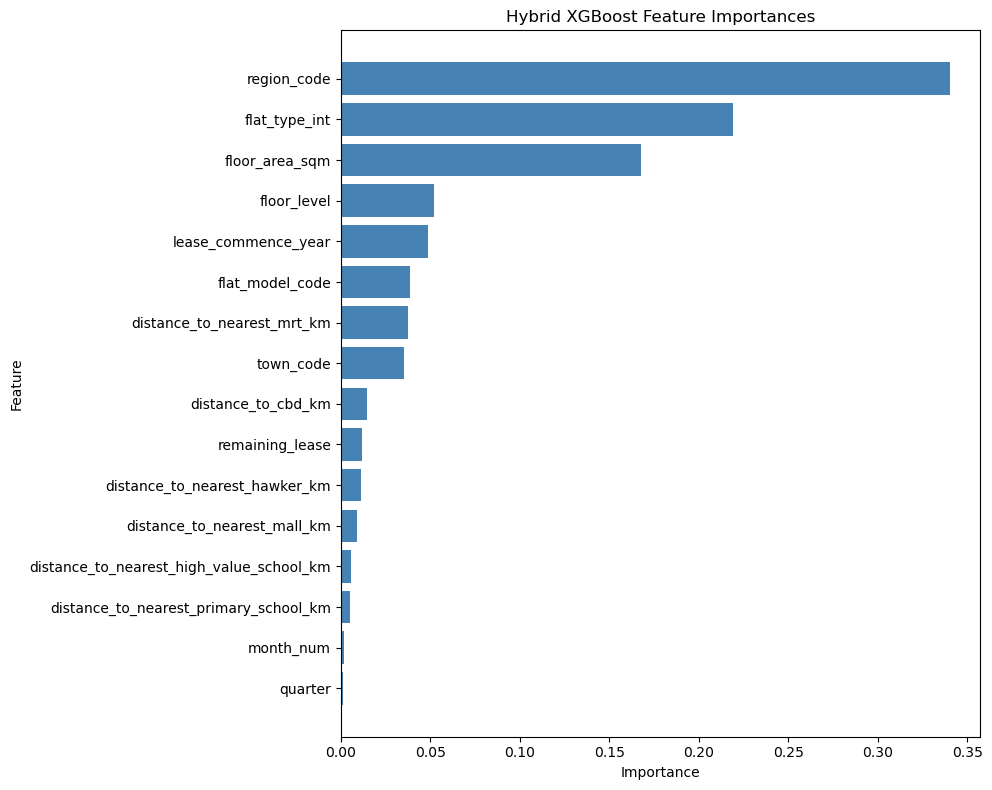


[OK] Chart saved: feature_importance.png


In [26]:
# Feature importance visualization
feature_importance = pd.DataFrame({
    'feature': HYBRID_FEATURES,
    'importance': final_hybrid_xgb.feature_importances_
}).sort_values('importance', ascending=True)

plt.figure(figsize=(10, 8))
plt.barh(feature_importance['feature'], feature_importance['importance'], color='steelblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Hybrid XGBoost Feature Importances')
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()
print("\n[OK] Chart saved: feature_importance.png")

---
## Summary

### Model Comparison Results

| Model | MAE | R² | Notes |
|-------|-----|-----|-------|
| Linear Regression | $86,056 | 0.6460 | Cannot capture non-linear patterns |
| Random Forest | $58,989 | 0.8606 | Good but slower |
| **XGBoost** | $57,258 | 0.8702 | Best performer for single-year |
| **Hybrid (XGB+Prophet)** | $36,439 | 0.9420 | **Best overall + future predictions** |

### Key Findings

1. **XGBoost outperforms** other models for property valuation
2. **Tree-based models cannot extrapolate** beyond training data range
3. **Hybrid approach solves** the future prediction problem:
   - XGBoost: Property valuation (location, size, lease, amenities)
   - Prophet: Market trend forecasting (price growth over time)
4. **Hybrid model achieves 36% better MAE** than standalone XGBoost
5. **Final formula**: `Price = XGBoost_base × Prophet_trend_multiplier`

### Hybrid Model Improvement

| Metric | Original XGBoost | Hybrid (XGB+Prophet) | Improvement |
|--------|------------------|----------------------|-------------|
| MAE | $57,142 | $36,439 | +36.2% |
| RMSE | $70,146 | $47,032 | +33.0% |
| R² | 0.8710 | 0.9420 | +7.1% |

### Files for Deployment

| File | Purpose |
|------|---------|
| `xgb_hybrid_base.joblib` | XGBoost model (trained on normalized prices) |
| `trend_multipliers.json` | Prophet trend multipliers (2015-2029) |
| `hybrid_model_features.json` | Feature configuration (16 features) |